# Associative Memory

This tutorial introduces the Associative Memory (AM) module in the SPA.

An associative memory is a neural network used to store and recall patterns.
When the network receives a partial or noisy pattern at the input, it can either recover
the same pattern or recall another stored pattern.
If the recovered pattern is the same as the input pattern, the memory is said to be
autoassociative or a *clean-up* memory. Otherwise, if the recovered pattern is different
from the presented one, the network is heteroassociative.

Patterns stored by the AM module in the SPA are semantic pointers organised in a SPA
vocabulary.
The examples in this tutorial demonstrate how to use the AM module to store and recall
patterns.
Advanced functionality of the module, such as the recall of multiple memories similar to
the input, is also presented.

A theoretical explanation on how the associative memory is implemented in NEF is
available in [Stewart et al.
2011](http://compneuro.uwaterloo.ca/publications/stewart2011.html).

In [1]:
%matplotlib inline

import nengo
import numpy as np
import matplotlib.pyplot as plt

import nengo_spa as spa

seed = 0
rng = np.random.RandomState(seed + 1)

## Step 1: Creating an Associative Memory

We start by creating a set of patterns the AM will store.
The vocabulary in this example contains five words: `ORANGE, APRICOT, CHERRY,
STRAWBERRY` and `APPLE`.
Each word is represented as a semantic pointer, an $n$-dimensional vector.
When creating a vocabulary, we specify the number of dimensions for all semantic
pointers.
Then, we add the words to the vocabulary with `populate`:

In [2]:
dim = 64
vocab = spa.Vocabulary(dimensions=dim, pointer_gen=rng)

words = ["ORANGE", "APRICOT", "CHERRY", "STRAWBERRY", "APPLE"]
vocab.populate(";".join(words))

Next, we create an autoassociative memory with a corresponding set of stored patterns.
To check the functionality of the memory module, we want to test whether the pattern at
the input has been successfully retrieved at the output.

The memory is created within a `spa.Network` module.
We set the Semantic Pointer `APPLE` as the input to the associative memory.
`nengo.Probe`s have been added to record inputs and outputs of the module, which we plot
for visual inspection.
Finally, we run the simulation for the 0.2 seconds simulation time.

In [3]:
with spa.Network("AssociativeMemory", seed=seed) as model:
    # create the AM module
    model.assoc_mem = spa.ThresholdingAssocMem(
        threshold=0.3, input_vocab=vocab, mapping=vocab.keys()
    )

    # present input to the AM
    spa.sym.APPLE >> model.assoc_mem

    # record the inputs and outputs during the simulation
    input_probe = nengo.Probe(model.assoc_mem.input)
    output_probe = nengo.Probe(model.assoc_mem.output, synapse=0.03)

with nengo.Simulator(model) as sim:
    sim.run(0.2)

We gather the simulation data:

In [4]:
print(f"Input dimensions: {tuple(sim.data[input_probe].shape)}")
print(f"Output dimensions: {tuple(sim.data[output_probe].shape)}")

Input dimensions: (200, 64)
Output dimensions: (200, 64)


We use a dot product (implemented in `spa.similarity`) to compare the similarity of
inputs and outputs to all patterns in the vocabulary at every time step. Recall that the
first dimension corresponds to the number of time steps and the second dimension to the
32-dimensional pattern represented in the associative memory.
If the similarity between the output vector and the input vector is close to one, we can
say that the associative memory successfully retrieved the pattern (or cleaned up the
input).

In [5]:
def plot_similarities(
    t_range, input_data, output_data, vocab1, vocab2=None, autoscale=False
):
    if vocab2 is None:
        vocab2 = vocab1

    ymin, ymax = -1.2, 1.2
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.ylim(ymin, ymax)
    if autoscale:
        plt.autoscale(autoscale, axis="y")
    plt.grid(True)
    plt.plot(t_range, spa.similarity(input_data, vocab1))
    plt.title("Input similarity")
    plt.xlabel("Time")
    plt.xlim(right=t_range[-1])
    plt.legend(
        list(vocab1.keys()), loc="upper center", bbox_to_anchor=(0.5, -0.13), ncol=3
    )

    plt.subplot(1, 2, 2)
    plt.plot(t_range, spa.similarity(output_data, vocab2))
    plt.title("Output similarity")
    plt.xlabel("Time")
    plt.xlim(right=t_range[-1])
    plt.ylim(ymin, ymax)
    if autoscale:
        plt.autoscale(autoscale, axis="y")
    plt.grid(True)
    plt.legend(
        list(vocab2.keys()), loc="upper center", bbox_to_anchor=(0.5, -0.13), ncol=3
    )
    plt.tight_layout()

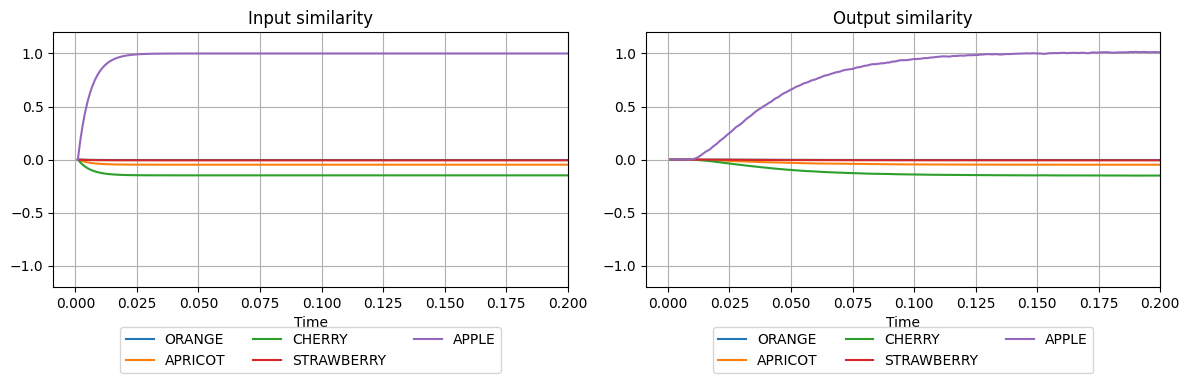

In [6]:
plot_similarities(sim.trange(), sim.data[input_probe], sim.data[output_probe], vocab)

We see that the network input has been constant throughout the simulation (`APPLE=1`).
Notice that there might be some small similarity between the pattern `APPLE` and some
other patterns. This is because the semantic pointers are not perfectly orthogonal and
the dot product will amount to some value different from zero. This can be improved by
increasing the dimensionality of vectors, yielding more orthogonal representations.
At the output, the similarity of the represented semantic pointer with the semantic
pointer `APPLE` increases until it reaches the maximal value (`=1`). This means that the
associative memory successfully retrieved the input pattern. The exponential increase is
due to the synaptic filtering in `nengo.Probe`. This is used to show how the input to
another group of neurons connected to the output of this particular AM module would look
like.

## Step 2: Clean-up Memory


In the next example, we show the ability of the associative memory to retrieve a clean
pattern from a noisy input. This is a very common use of autoassociative memories, also
called *clean-up* as the AM removes the noise in the input.

First, we construct a noisy semantic pointer to be cleaned up by using a combination of
several semantic pointers. This is done by passing the expression
`0.9*APPLE+0.5*CHERRY+0.4*APRICOT` as the input to the the network. The resulting input
vector will still be mostly similar to one semantic pointer (`APPLE`) but is also
somewhat similar to other semantic pointers in the vocabulary. Therefore, the task of
the network will be to clean up the vector `APPLE`.

### Thresholding Memory

One way to achieve this in SPA is by using the thresholding mechanism in the AM module.
By specifying the threshold, the output will be similar only to those inputs whose
similarity with a vocabulary item is above a certain value. In this example we will
increase the selectivity of the AM by setting the threshold to to a higher value.

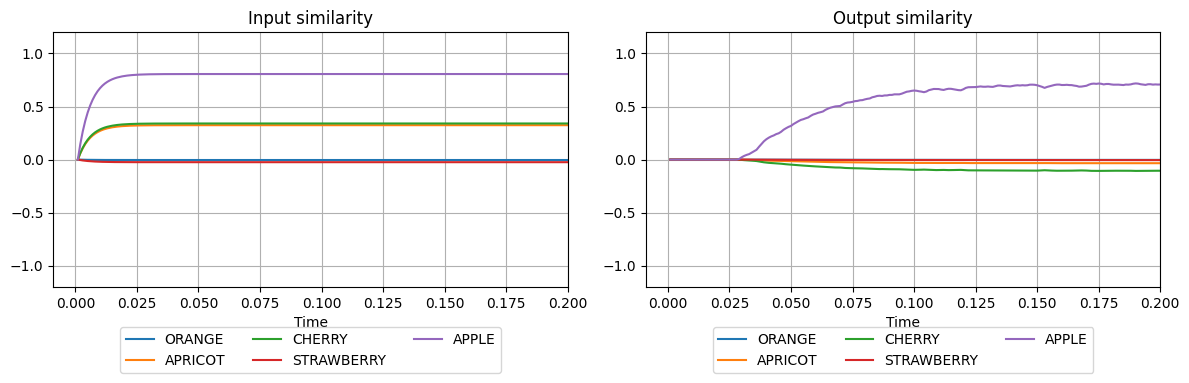

In [7]:
with spa.Network("CleanupThreshold", seed=seed) as model:
    model.assoc_mem = spa.ThresholdingAssocMem(
        threshold=0.7, input_vocab=vocab, mapping=vocab.keys()
    )

    (
        0.9 * spa.sym.APPLE + 0.5 * spa.sym.CHERRY + 0.4 * spa.sym.APRICOT
        >> model.assoc_mem
    )

    input_probe = nengo.Probe(model.assoc_mem.input)
    output_probe = nengo.Probe(model.assoc_mem.output, synapse=0.03)

with nengo.Simulator(model) as sim:
    sim.run(0.2)

plot_similarities(sim.trange(), sim.data[input_probe], sim.data[output_probe], vocab)

We see that the vector at the input is mostly similar to the semantic pointer `APPLE`
and somewhat similar to the semantic pointer `CHERRY`. The vector at the output is very
similar to the `APPLE`, indicating that the memory successfully cleaned up the noisy
pattern.

However, the output of `APPLE` isn't of similarity `1.0`. To achieve this, we can change
the output mapping of the memory, so any output maps to maximum similarity, by making it
computer the function `x > 0` on all outputs `x`. This will produce a vector at the
output which has similarity one with the semantic pointer `APPLE`.

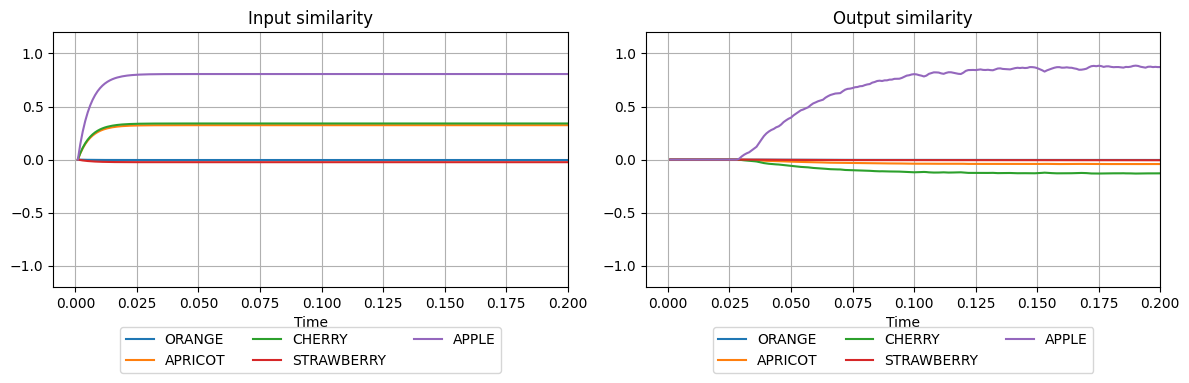

In [8]:
with spa.Network("CleanupThreshold", seed=seed) as model:
    model.assoc_mem = spa.ThresholdingAssocMem(
        threshold=0.7,
        input_vocab=vocab,
        mapping=vocab.keys(),
        function=lambda x: x > 0.0,
    )

    (
        0.9 * spa.sym.APPLE + 0.5 * spa.sym.CHERRY + 0.4 * spa.sym.APRICOT
        >> model.assoc_mem
    )

    input_probe = nengo.Probe(model.assoc_mem.input)
    output_probe = nengo.Probe(model.assoc_mem.output, synapse=0.03)

with nengo.Simulator(model) as sim:
    sim.run(0.2)

plot_similarities(sim.trange(), sim.data[input_probe], sim.data[output_probe], vocab)

## WTA Memory

In some modelling scenarios we might have an input vector which is very similar to
several other vectors in the vocabulary:

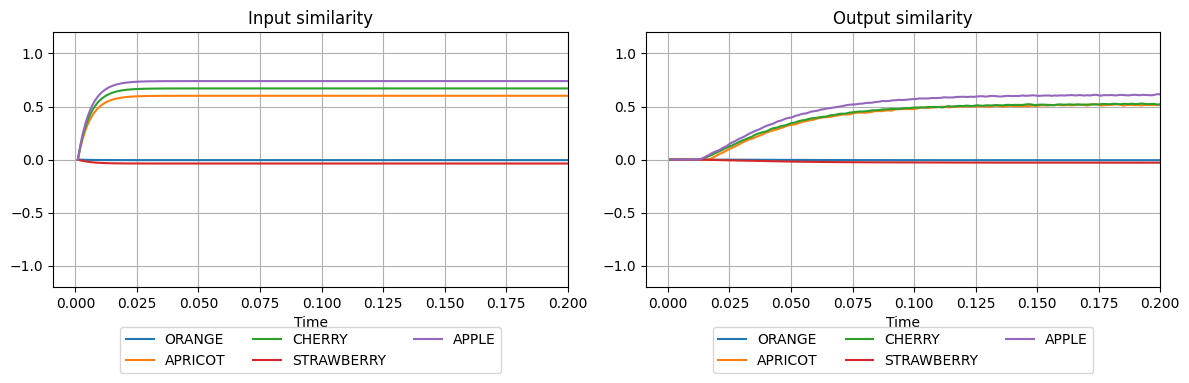

In [9]:
with spa.Network("Cleanup", seed=seed) as model:
    model.assoc_mem = spa.ThresholdingAssocMem(
        threshold=0.3, input_vocab=vocab, mapping=vocab.keys()
    )

    (
        0.9 * spa.sym.APPLE + 0.85 * spa.sym.CHERRY + 0.7 * spa.sym.APRICOT
        >> model.assoc_mem
    )

    input_probe = nengo.Probe(model.assoc_mem.input)
    output_probe = nengo.Probe(model.assoc_mem.output, synapse=0.03)

with nengo.Simulator(model) as sim:
    sim.run(0.2)

plot_similarities(sim.trange(), sim.data[input_probe], sim.data[output_probe], vocab)

We see that the input is very similar to semantic pointers `APPLE` and `CHERRY`, and
somewhat similar to `APRICOT`.
In this situation, it might be difficult to determine a fixed threshold which will clean
up the input and differentiate between the vectors `APPLE` and `CHERRY`. To ensure that
only one vector at the output is similar to the strongest input, we can use
`spa.WTAAssocMem` instead of `spa.ThresholdingAssocMem`. `WTA` is a computational
principle called winner-take-all, stating that one, mostly active element should be
regarded as the winner among possible, less similar alternatives.

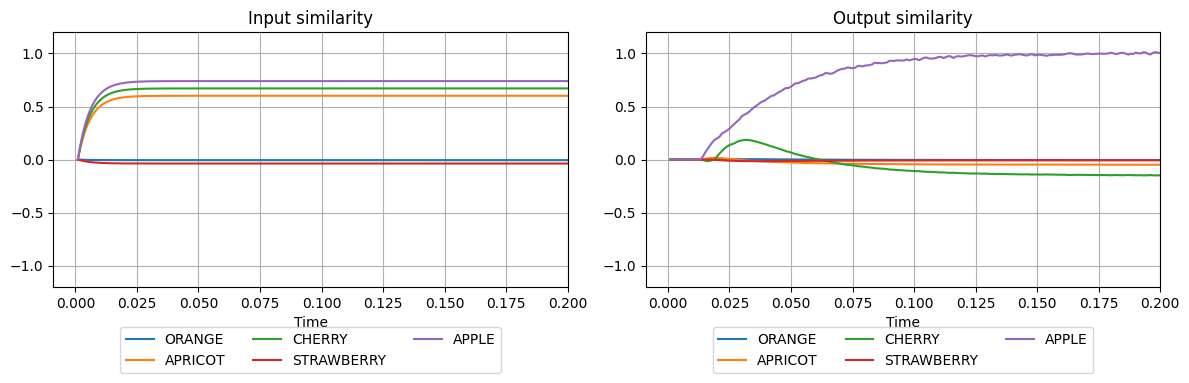

In [10]:
with spa.Network("CleanupWTA", seed=seed) as model:
    model.assoc_mem = spa.WTAAssocMem(
        threshold=0.3,
        input_vocab=vocab,
        mapping=vocab.keys(),
        function=lambda x: x > 0.0,
    )

    (
        0.9 * spa.sym.APPLE + 0.85 * spa.sym.CHERRY + 0.7 * spa.sym.APRICOT
        >> model.assoc_mem
    )

    input_probe = nengo.Probe(model.assoc_mem.input)
    output_probe = nengo.Probe(model.assoc_mem.output, synapse=0.03)

with nengo.Simulator(model) as sim:
    sim.run(0.2)

plot_similarities(sim.trange(), sim.data[input_probe], sim.data[output_probe], vocab)

Although the input vector is very similar to both `APPLE` and `CHERRY`, the memory
manages to recover the `APPLE` at the output.

## Step 3: Heteroassociative relationships

To model a variety of interesting memory phenomena, it is often useful to store
relationships between different sets of patterns.
For example, to simulate number counting from 1 to 5, the memory needs to store the
relationships between patterns representing numbers:
$1\rightarrow2,\ 2\rightarrow3,\ 3\rightarrow4,\ 4\rightarrow5$

In this example we show how to use `spa.WTAAssocMem` for this task. In order to achieve
the number counting, we will split the task into two parts:

1. Present a number at the input and recall a number greater by one (e.g. for `1` recall
`2`, for `2` recall `3` etc.)

2. Feed the output of the associative memory back to its input


As in the previous example, we start by defining a vocabulary that stores semantic
pointers representing five numbers. This will be used as the input and as the output
vocabulary. In case of hetero-associative memories the input and the output vocabulary
can differ.

In [11]:
dim = 16
vocab_numbers = spa.Vocabulary(dimensions=dim)

vocab_numbers.populate("ONE; TWO; THREE; FOUR; FIVE")

Now, in function `input_fun` we define which semantic pointer is going to be present at
the input at certain simulation time. Because we want to achieve a heteroassociative
mapping, we need to specify which input patterns map to which output patterns. The
desired mapping is specified by providing the `mapping` argument when creating the AM
module:

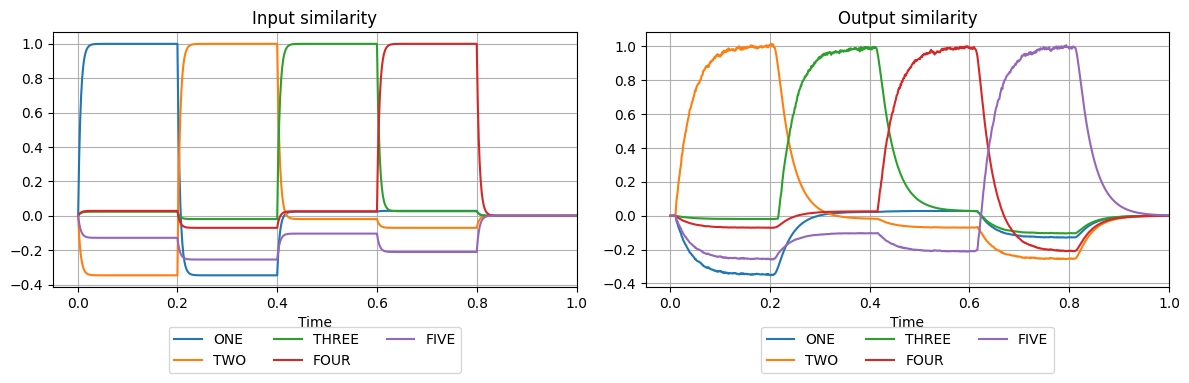

In [12]:
def input_fun(t):
    if t < 0.2:
        return "ONE"
    elif t < 0.4:
        return "TWO"
    elif t < 0.6:
        return "THREE"
    elif t < 0.8:
        return "FOUR"
    else:
        return "0"


# from patterns
mapping = {
    "ONE": "TWO",
    "TWO": "THREE",
    "THREE": "FOUR",
    "FOUR": "FIVE",
}

with spa.Network("Counting", seed=seed) as model:
    model.assoc_mem = spa.WTAAssocMem(
        threshold=0.3,
        input_vocab=vocab_numbers,
        mapping=mapping,
        function=lambda x: x > 0.0,
    )

    model.am_input = spa.Transcode(input_fun, output_vocab=vocab_numbers)
    model.am_input >> model.assoc_mem

    input_probe = nengo.Probe(model.assoc_mem.input)
    output_probe = nengo.Probe(model.assoc_mem.output, synapse=0.03)

with nengo.Simulator(model) as sim:
    sim.run(1.0)

plot_similarities(
    sim.trange(),
    sim.data[input_probe],
    sim.data[output_probe],
    vocab_numbers,
    autoscale=True,
)

So far we have created a model which realises increments by one. The next step is to
automatise this, so that when the model sees `ONE` it will produce `TWO, THREE, FOUR,
FIVE`.
To achieve counting, we need to introduce a feedback connection. That is, the network
output needs to be fed into its input at the next time step. This can be easily done in
Nengo by adding just one additional connection. Now, we initialise the simulation by
presenting the semantic pointer `ONE` at the input for the duration of 0.2 simulation
time.

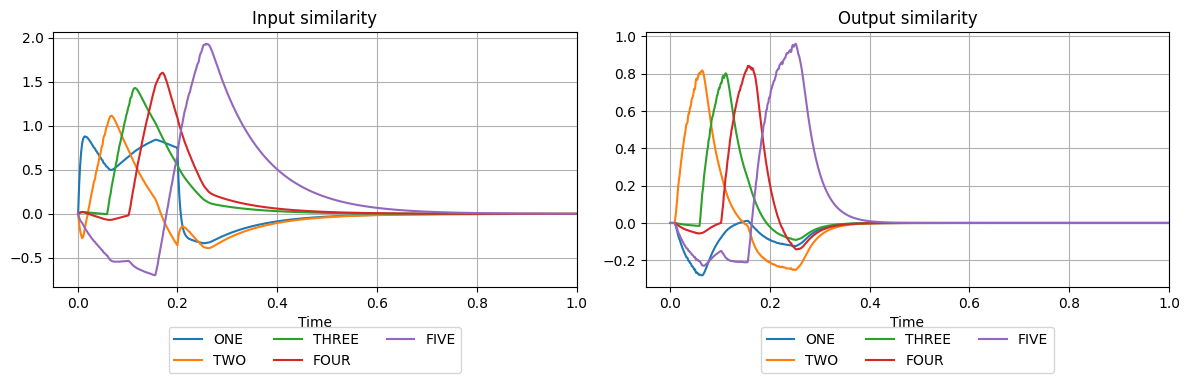

In [13]:
def input_fun2(t):
    if 0 < t < 0.2:
        return "ONE"
    else:
        return "0"


with spa.Network("Counting", seed=seed) as model:
    model.assoc_mem = spa.WTAAssocMem(
        threshold=0.3,
        input_vocab=vocab_numbers,
        output_vocab=vocab_numbers,
        mapping=mapping,
        function=lambda x: x > 0.0,
    )

    model.am_input = spa.Transcode(input_fun2, output_vocab=vocab_numbers)
    model.am_input >> model.assoc_mem

    # added feedback connection
    nengo.Connection(
        model.assoc_mem.output, model.assoc_mem.input, synapse=0.10, transform=3.5
    )

    input_probe = nengo.Probe(model.assoc_mem.input)
    output_probe = nengo.Probe(model.assoc_mem.output, synapse=0.03)

with nengo.Simulator(model) as sim:
    sim.run(1.0)

plot_similarities(
    sim.trange(),
    sim.data[input_probe],
    sim.data[output_probe],
    vocab_numbers,
    autoscale=True,
)

The only input our model receives is `ONE` at the beginning of the simulation. After
that, it produces a sequence of consecutive numbers up to five. The connection
parameters `synapse` and `transform` have been set to arbitrary values which produce the
desired sequence. Try modifying them to see how they affect the behaviour.